# Trajectory planning for multi-agent systems

Multi-agent path finding (MAPF) is a problem that has been studied for a large number of years for applications including robotics, aviation, video games, and more [[Dresner and Stone 2008](https://www.jair.org/index.php/jair/article/download/10542/25241),
[Ma et al. 2017](https://ojs.aaai.org/index.php/AIIDE/article/download/12919/12767),
[Pallottino et al. 2007](https://ieeexplore.ieee.org/iel5/8860/4399947/04392815.pdf?casa_token=HP6WWjHKswQAAAAA:ua93qnZ1EBG34GM6r84yNkR5h7uZqYqh3HjF8xB0_zhIMlWwmuI8RMIJ6h-QWElqXOZlSg),
[Silver 2005](https://ojs.aaai.org/index.php/AIIDE/article/download/18726/18503),
[Wurman et al. 2008](http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/robert_kiva_paper.pdf)]. It raises the question of how multiple agents can reach their goal position without colliding with each other.

In this case study we are using contracts defined in pacti to ensure that the resulting path is conflict-free. We are focusing on vertex conflicts, where two or more agents cannot share a grid cell, and swapping conflicts, preventing two agents from swapping positions in two adjacent cells. For a detailed survey on objective functions and conflict types, see [[Stern et al. 2019](https://arxiv.org/abs/1906.08291)].

In the following section we will explain the problem setup and illustrate our approach of using contracts to find a safe strategy for the robots. The benefit of using contracts for this application is how modularly we can add/remove robots or additional contraints to the problem.

In the video below you can see the implementation of the resulting strategy for five robots on the
[Robotarium](https://www.robotarium.gatech.edu) [[Wilson et al. 2020](https://ieeexplore.ieee.org/iel7/5488303/8960558/08960572.pdf?casa_token=5GsOySsxPm4AAAAA:gVhO3ngOXJzZ-gnupam3LFl5EDInm50sLy4BTUP8zqxuDvAMRyMKNAp_bPOvBPKmcYbjZg)].

![Robotarium Implementation](https://github.com/pacti-org/media/blob/main/case_studies/multiagent_coordination/robotarium.gif?raw=true)


This case study shows how Pacti can be used to formalize a multiagent navigation problem and synthesize a strategy for the robots to reach their respective goal position without crashing into each other.

We will start by importing the relevant packages.

In [1]:
%matplotlib inline
import numpy as np
from utils.multiagent_utils import (
    Coord,
    Robot,
    distance,
    find_random_move,
    get_collision_contract,
    get_swapping_contract,
    check_move
)
from utils.plotting_utils import (
    Snapshot,
    animate,
    plot_grid_world,
    save_trace
)
from utils.swapping_contract import get_swapping_contracts_list
from utils.collision_contract import get_collision_contracts_list
from utils.stay_at_goal_contract import robots_stay_at_goal
from utils.dynamics_contract import get_dynamics_contract

from utils.optimize_utils import optimize_contract
from utils.behavior_utils import ntl_contains_behavior, tl_contains_behavior, extend_var_dict

from pacti.iocontract import Var
from pacti.contracts import PolyhedralIoContract, PolyhedralIoContractCompound
from typing import List
from itertools import combinations
import random

### Create gridworld and robots

First we will create the grid world with the dimensions $grid_{n} \times grid_{m}$ for our robots to move in. Each robot starts at their respective initial condition, with the task to reach its goal position on the grid. 
To initialize the robots and set up the grid world, we will call the functions that we imported from multiagent_utils.

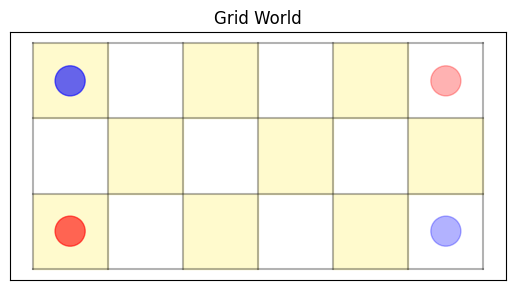

In [2]:
# Define the grid world dimensions n x m
grid_n = 6
grid_m = 3

# Initialize the robots
r1 = Robot("A", (0, 0), (5, 2))
r2 = Robot("B", (0, 2), (5, 0))
robots = [r1, r2]

plot_grid_world(grid_n, grid_m, robots)

### Define dynamics contracts for each robot per timestep

We will break up the execution into individual timesteps as our planning horizon to reduce the complexity of the planning problem. This horizon length can be increased depending on the problem to be solved, but for the purpose of this case study we will do our planning in increments of single time steps.

The figure below will give an overview of the process per timestep, on the right we will see the resulting traces of the robots when following a strategy found using Pacti.

![Overview Figure](https://github.com/pacti-org/media/blob/main/case_studies/multiagent_coordination/multiagent_overview.png?raw=true)

This figure shows how we will use the contracts for each time step to place constraints on the movement of the robots. The contracts that we will take into account are $\mathcal{C}_{\text{dyn}}$, which describes the dynamics of each robot,  $\mathcal{C}_{\text{collision}}$, which will ensure that no two robots will occupy the same grid cell, and  $\mathcal{C}_{\text{swapping}}$, which ensure that two robots cannot swap positions (they would collide during the transition). For each time step we will repeat this process and update the positions of the robots according to the chosen move. Applying this strategy will result in a trajectory as shown on the right side of the figure.

Now we define the contracts for the robots' dynamics, the input variables are the current position of each robot in $x$ and $y$ coordinates and the current timestep $t=i$. The output variables are the next position of the robots $(x_{i+1},y_{i+1})$ and the next timestep $i+1$. 

In the assumptions we define the initial positions and time step as the current position of the robot and the current timestep:

$$
\begin{align*}
t_i &= t \\
x_i &= x \\
y_i &= y
\end{align*}
$$

The guarantees of the contract are defining the dynamics and ensure that the time step increases by 1.

$$
t_{i+1} - t_i = 1
$$

The dynamics allow any single cell vertical or horizontal transitions to an adjacent cell on the grid (but not diagonal) and are specified as

$$
|x_i - x_{i+1}| + |y_i - y_{i+1}| \leq 1.
$$

We will break this constraint up into four separate constraints:

$$
\begin{align*}
& x_{i+1} - x_i + y_{i+1} - y_i \leq 1 \\
& x_{i+1} - x_i - y_{i+1} + y_i \leq 1 \\
& -x_{i+1} + x_i + y_{i+1} - y_i \leq 1 \\
& -x_{i+1} + x_i - y_{i+1} + y_i \leq 1
\end{align*}
$$

We also ensure that the robot has to remain within the grid, specified as:

$$
\begin{align*}
&x_{i+1} < grid_n \\
&y_{i+1} < grid_m
\end{align*}
$$

Note that we need one dynamics contract for each robot, as the contract can only describe the dynamics for the robot whose behavior it describes. We are extending the input and output variables to include the variables for the other robots and the other contracts that we will use later, but each robot's dynamics contract only specifies the guarantees for its respecive robot's coordinates for the next timestep. In the code the subscript $0$ corresponds to timestep $i$ and the subscript $1$ corresponds to timestep $i+1$.

This contract implementing the constraints explained above is defined in the following function:

In [2]:
def get_dynamics_contract_robot(name: str, init_pos: Coord, timestep: int) -> PolyhedralIoContract:  # noqa: WPS210
    """
    Function to set up the contract encoding the dynamics for a single robot for the next timestep.

    Args:
        name: name of the robot
        init_pos: current coordinates of the robot
        timestep: current timestep

    Returns:
        Resulting contract compound that encodes the dynamics for the robot.
    """
    x_str_0 = 'x_{0}_0'.format(name)
    y_str_0 = 'y_{0}_0'.format(name)
    x_str_1 = 'x_{0}_1'.format(name)
    y_str_1 = 'y_{0}_1'.format(name)
    t_0 = 't_0'
    t_1 = 't_1'

    contract = PolyhedralIoContract.from_strings(
        input_vars=[x_str_0, y_str_0, t_0],
        output_vars=[x_str_1, y_str_1, t_1],
        assumptions=[
                "{0} = {1}".format(x_str_0, init_pos.x),
                "{0} = {1}".format(y_str_0, init_pos.y),
                "{0} = {1}".format(t_0, timestep),
        ],
        guarantees=[
                "{0} - {1} = 1".format(t_1, t_0),
                "{0} - {1} + {2} - {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "{0} - {1} - {2} + {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "-{0} + {1} + {2} - {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "-{0} + {1} - {2} + {3} <= 1".format(x_str_1, x_str_0, y_str_1, y_str_0),
                "{0} <= {1}".format(x_str_1, grid_n - 1),
                "{0} <= {1}".format(y_str_1, grid_m - 1),
                "-{0} <= 0".format(x_str_1),
                "-{0} <= 0".format(y_str_1),
        ],
    )
    return contract

### Collision Conflict Contract
Next we describe the contracts that will ensure that our robots do not collide. For this we will place constraints on the distance between a pair of robots, and ensure that is will always be larger or equal to one cell - meaning two robots will never share the same cell (i.e. collide).

To describe the this requirement in linear inequalities, we need to break up the collision requirement into four inequalities. Each inequality will place constraints on both robots for a specific configuration with regards to each other (for example robot A is to the top right of robot B). 

As the guarantees of these contracts are mutually exclusive (robots can only be in one configuration at a time - Robot A cannot be to the right and to the left of robot B at the same time), we need to consider each of these collision quadrants separately in our analysis. To achieve this, we are using a `PolyhedralIoContractCompound` which allows for disjoint guarantees (and disjoint assumptions if desired).

The linear inequalities ensuring no collision for two robots $A$ and $B$ are defined as follows.

We assume that the two robots do not collide:

$$
\text{distance}(A,B) \geq 1
$$

The guarantees are that at least one of these inequalities is satisfied:

$$
\begin{align*}
&x^A_1 - x^B_1 + y^A_1 - y^B_1 \leq -1 \\
&x^A_1 - x^B_1 - y^A_1 + y^B_1 \leq -1 \\
&x^A_1 + x^B_1 + y^A_1 - y^B_1 \leq -1 \\
&x^A_1 + x^B_1 - y^A_1 + y^B_1 \leq -1
\end{align*}
$$

In [3]:
def collision_contract(robot_1: Robot, robot_2: Robot) -> PolyhedralIoContractCompound:
    """
    Function to ensure no collisions between two robots.

    Returns:
        Resulting contract compound that ensures no collisions.
    """
    outputvars = [
        "x_" + str(robot_1.name) + "_1",
        "y_" + str(robot_1.name) + "_1",
        "x_" + str(robot_2.name) + "_1",
        "y_" + str(robot_2.name) + "_1",
    ]

    contract = PolyhedralIoContractCompound.from_strings(
        input_vars=["current_distance"],
        output_vars= outputvars,
        assumptions=[["-current_distance <= -1"]],
        guarantees=[
            ["x_"+robot_1.name+ "_1 - x_" +robot_2.name+ "_1 + y_" +robot_1.name+ "_1 - y_" +robot_2.name+ "_1 >= 1"],
            ["-x_"+robot_1.name+ "_1 + x_" +robot_2.name+ "_1 - y_" +robot_1.name+ "_1 + y_" +robot_2.name+ "_1 >= 1"],
            ["x_"+robot_1.name+ "_1 - x_" +robot_2.name+ "_1 - y_" +robot_1.name+ "_1 + y_" +robot_2.name+ "_1 >= 1"],
            ["-x_"+robot_1.name+ "_1 + x_" +robot_2.name+ "_1 + y_" +robot_1.name+ "_1 - y_" +robot_2.name+ "_1 >= 1"],
            
        ],
    )
    return contract

### Swapping Contract
Next we define the contract that determines that the robots will also stay collision free during their transition to another cell, meaning that two robots cannot swap places in the grid, as they would collide while traversing the same edge in opposite directions. We do this by defining another contract with a disjoint guarantee sets.
What we want to enforce is that the two robots cannot swap positions, given as:
$$
\begin{align*}
\vert x_{i}^{A}-x_{i+1}^{B}\vert+\vert y_{i}^{A}-y_{i+1}^{B}\vert \neq 0 \quad \text{ or }\quad \vert x_{i}^{B}-x_{i+1}^{A}\vert +\vert y_{i}^{B}-y_{i+1}^{A}\vert \neq 0.
\end{align*}
$$
We encode this constraint in the following four constraints:
$$
\begin{align*}
&(x_{i}^{A}-x_{i+1}^{B})+(y_{i}^{A}-y_{i+1}^{B}) \geq 1\\
&(x_{i}^{A}-x_{i+1}^{B})+(y_{i}^{A}-y_{i+1}^{B}) \geq -1\\
&(x_{i}^{B}-x_{i+1}^{A})+(y_{i}^{B}-y_{i+1}^{A}) \geq 1\\
&(x_{i}^{B}-x_{i+1}^{A})+(y_{i}^{B}-y_{i+1}^{A}) \geq -1
\end{align*}
$$
 
Where we need at least one of these inequalities to be satisfied. This contract does not state a specific assumption on the agent's positions.

In [5]:
def swapping_contract(robot_1: Robot, robot_2: Robot) -> PolyhedralIoContractCompound:
    """
    Contract ensuring no swapping for a pair of robots.

    Args:
        robot_1: Name of robot 1.
        robot_2: Name of robot 2.

    Returns:
        The compound contract that ensures no collision.
    """
    inputvars = [
        "x_" + str(robot_1.name) + "_0",
        "y_" + str(robot_1.name) + "_0",
        "x_" + str(robot_2.name) + "_0",
        "y_" + str(robot_2.name) + "_0",
    ]
    outputvars = [
        "x_" + str(robot_1.name) + "_1",
        "y_" + str(robot_1.name) + "_1",
        "x_" + str(robot_2.name) + "_1",
        "y_" + str(robot_2.name) + "_1",
    ]

    contract = PolyhedralIoContractCompound.from_strings(
        input_vars=inputvars,
        output_vars=outputvars,
        assumptions=[[]],
        guarantees=[
            ["x_"+robot_1.name+ "_1 - x_" +robot_2.name+ "_0 + y_" +robot_1.name+ "_1 - y_" +robot_2.name+ "_0 >= 1"],
            ["x_"+robot_1.name+ "_1 - x_" +robot_2.name+ "_0 + y_" +robot_1.name+ "_1 - y_" +robot_2.name+ "_0 <= -1"],
            ["x_"+robot_2.name+ "_1 - x_" +robot_1.name+ "_0 + y_" +robot_2.name+ "_1 - y_" +robot_1.name+ "_0 >= 1"],
            ["x_"+robot_2.name+ "_1 - x_" +robot_1.name+ "_0 + y_" +robot_2.name+ "_1 - y_" +robot_1.name+ "_0 <= -1"],
            ]
        )
    return contract

Now we use Pacti to create the contracts from the functions and display them to confirm we set them up as desired.

In [6]:
c_dyn_a = get_dynamics_contract_robot(r1.name, r1.pos, 0)
c_dyn_b = get_dynamics_contract_robot(r2.name, r2.pos, 0)
c_collision = collision_contract(r1, r2)
c_swapping = swapping_contract(r1, r2)

print("Dynamics Contract Robot A:\n {0} \n".format(c_dyn_a))
print("Dynamics Contract Robot B:\n {0} \n".format(c_dyn_b))
print("Collision Contract:\n {0} \n".format(c_collision))
print("Swapping Contract:\n {0}".format(c_swapping))

Dynamics Contract Robot A:
 InVars: [x_A_0, y_A_0, t_0]
OutVars:[x_A_1, y_A_1, t_1]
A: [
  x_A_0 = -0
  y_A_0 = -0
  t_0 = -0
]
G: [
  -t_0 + t_1 = 1
  -x_A_0 + x_A_1 - y_A_0 + y_A_1 <= 1
  -x_A_1 <= 0
  -y_A_1 <= 0
] 

Dynamics Contract Robot B:
 InVars: [x_B_0, y_B_0, t_0]
OutVars:[x_B_1, y_B_1, t_1]
A: [
  x_B_0 = -0
  y_B_0 = 2
  t_0 = -0
]
G: [
  -t_0 + t_1 = 1
  -x_B_0 + x_B_1 + y_B_0 - y_B_1 <= 1
  y_B_1 <= 2
  -x_B_1 <= 0
] 

Collision Contract:
 InVars: [current_distance]
OutVars:[x_A_1, y_A_1, x_B_1, y_B_1]
A: [
  -current_distance <= -1
]
G: [
  -x_A_1 + x_B_1 - y_A_1 + y_B_1 <= -1
]
or 
[
  x_A_1 - x_B_1 + y_A_1 - y_B_1 <= -1
]
or 
[
  -x_A_1 + x_B_1 + y_A_1 - y_B_1 <= -1
]
or 
[
  x_A_1 - x_B_1 - y_A_1 + y_B_1 <= -1
] 

Swapping Contract:
 InVars: [x_A_0, y_A_0, x_B_0, y_B_0]
OutVars:[x_A_1, y_A_1, x_B_1, y_B_1]
A: [
  
]
G: [
  -x_A_1 + x_B_0 - y_A_1 + y_B_0 <= -1
]
or 
[
  x_A_1 - x_B_0 + y_A_1 - y_B_0 <= -1
]
or 
[
  x_A_0 - x_B_1 + y_A_0 - y_B_1 <= -1
]
or 
[
  -x_A_0 

### Merging the dynamics contracts
We are ready to start merging the contracts. We start by merging the dynamics contracts for each of the robots. This contract now holds all the information for possible steps that both robots can take, but it does not ensure no collisions yet. Now let's take a look at the contract describing the dynamics for both robots.

In [7]:
c_combined_dynamics = c_dyn_a.merge(c_dyn_b)
print(c_combined_dynamics)

InVars: [x_A_0, y_A_0, t_0, x_B_0, y_B_0]
OutVars:[x_A_1, y_A_1, t_1, x_B_1, y_B_1]
A: [
  x_A_0 = -0
  y_A_0 = -0
  t_0 = -0
  x_B_0 = -0
  y_B_0 = 2
]
G: [
  -t_0 + t_1 = 1
  -x_A_0 + x_A_1 - y_A_0 + y_A_1 <= 1
  -x_A_1 <= 0
  -y_A_1 <= 0
  -x_B_0 + x_B_1 + y_B_0 - y_B_1 <= 1
  y_B_1 <= 2
  -x_B_1 <= 0
]


Next we can use the dynamics contract to find a possible next move for the robots that minimizes an objective. Our objective is minimizing the distance to the goal for the two robots A and B:
$$
\vert x_{i+1}^{A}-x_{\text{goal}}^{A}\vert +\vert y_{i+1}^{A}-y_{\text{goal}}^{A}\vert + \vert x_{i+1}^{B}-x_{\text{goal}}^{B}\vert +\vert y_{i+1}^{B}-y_{\text{goal}}^{B}\vert
$$

In [4]:
# set objective (cumulative distance to the goal)
def objective_expr(robots: List[Robot]) -> str:
    '''
    Function returning a string describing the cumulative euclidian distance for the robots to their goals.
    Args:
        robots: List of robots.

    Returns:
        The string that describes the objective.
    '''
    expr = ''
    for robot in robots:
        sgn_x = np.sign((robot.goal.x - robot.pos.x))
        sgn_y = np.sign((robot.goal.y - robot.pos.y))

        if sgn_x < 0:
            expr += "(-"+ str(robot.goal.x) + " + x_"+ str(robot.name) + "_1) + "
        elif sgn_x > 0:
            expr += "("+ str(robot.goal.x) + " - x_"+ str(robot.name) + "_1) + "
        else:
            expr += "(-"+ str(robot.goal.x) + " + x_"+ str(robot.name) + "_1) + "
            expr += "("+ str(robot.goal.x) + " - x_"+ str(robot.name) + "_1) + "

        if sgn_y < 0:
            expr += "( y_"+ str(robot.name) + "_1 -"+ str(robot.goal.y) + ") + "
        if sgn_y > 0:
            expr += "("+ str(robot.goal.y) + " - y_"+ str(robot.name) + "_1) + "
        else:
            expr += "( y_"+ str(robot.name) + "_1 -"+ str(robot.goal.y) + ") + "
            expr += "("+ str(robot.goal.y) + " - y_"+ str(robot.name) + "_1) + "

    expr = expr[:-2]

    return expr

We can now use the objective and the dynamics contract to find the next best move to take.

In [9]:
fun_val, var_dict = optimize_contract(contract=c_combined_dynamics, expr=objective_expr(robots), maximize=False)

We need to extend the result of the optimization in the form of a 'variable dictionary' with the current distance between the robots to be able to evaluate the other contracts for this proposed solution.

In [10]:
vars = {}
for key in var_dict.keys():
    vars.update({key.name: var_dict[key]})
    
robotcombis = combinations(robots, 2)
cur_dist = np.inf
for combi in list(robotcombis):
    distance_btw_robots = np.abs(combi[0].pos.x - combi[1].pos.x) + np.abs(combi[0].pos.y - combi[1].pos.y)
    cur_dist = min(cur_dist, distance_btw_robots)

var_dict.update({Var("current_distance"): cur_dist})

We can now use this dictionary to check whether the move satisfies the swapping and the collision contract. If it does we can apply it to the robots, otherwise we will take a random move.

In [11]:
move_ok = True
if not c_swapping.g.contains_behavior(var_dict):
    move_ok = False
if not c_collision.a.contains_behavior(var_dict) or not c_collision.g.contains_behavior(var_dict):
    move_ok = False

if move_ok:
    move = [(var_dict[Var("x_"+robot.name+"_1")], var_dict[Var("y_"+robot.name+"_1")]) for robot in robots]
    print('The robots can take the optimal move {}'.format(move))

The robots can take the optimal move [(1.0, -0.0), (1.0, 2.0)]


We also introduce another move type, a random move, where the robots have to satisfy all their contracts, but do not need to reduce their cumulative distance to the goal.
To do this we find the possible next positions and choose a random element, then we check whether it satisfies all contracts. If not we remove that move from the possible options and try a different move.

In [12]:
if not move_ok:
    move = find_random_move(grid_n, grid_m, robots, t_0, multiagent_contract, [collision_contract], [swapping_contract])
    print('The robots will take a random move {}'.format(move))

Now we can put everything together and run the simulation of our two robots navigating the grid together.

Note: If you do not have `ffmpeg` install, you will need to install it to create the animation (https://www.ffmpeg.org).

In [15]:
grid_n = 5
grid_m = 5

r1 = Robot("A", (0, 1), (4, 3))
r2 = Robot("B", (0, 3), (4, 1))
trace: List[Snapshot] = []
robots = [r1, r2]
num_iter = grid_n * len(robots) * 3

t_0 = 0
trace = save_trace(
    trace, [(r1.pos.x, r1.pos.y), (r2.pos.x, r2.pos.y)], [(r1.goal.x, r1.goal.y), (r2.goal.x, r2.goal.y)]
)

# Create the contracts ensuring no conflicts
c_collision = collision_contract(r1, r2)
c_swapping = swapping_contract(r1, r2)

c_collision_list = [c_collision]
c_swapping_list = [c_swapping]

random_move_nrs = 0

for _i in range(0, num_iter):  # noqa: WPS122
    # find the current distance to the goal
    to_goal = distance([[robot.pos.x, robot.pos.y] for robot in robots], [robot.goal for robot in robots])
    
    # set up the dynamics contracts
    c_dyn1 = get_dynamics_contract_robot(r1.name, r1.pos, t_0)
    c_dyn2 = get_dynamics_contract_robot(r2.name, r2.pos, t_0)
    multiagent_contract = c_dyn1.merge(c_dyn2)

    # add stay at goal
    goal_contract = robots_stay_at_goal(robots, t_0)
    multiagent_contract = multiagent_contract.merge(goal_contract)
    
    # set the objective
    expr = objective_expr(robots)
    
    # optimize over the contract by minimizing the objective
    fun_val, var_dict = optimize_contract(contract=multiagent_contract, expr=expr, maximize=False)
    var_dict = extend_var_dict(var_dict, robots)

    move = [(var_dict[Var("x_"+robot.name+"_1")], var_dict[Var("y_"+robot.name+"_1")]) for robot in robots]
    
    move_ok = check_move(var_dict, c_collision_list, c_swapping_list)
    
    if to_goal <= 3: # if the robots are close to the goal take the optimal move or take 3 random moves if that is not possible
        if move_ok and random_move_nrs == 0:
            print('The robots can take the optimal move {}'.format(move))
        elif not move_ok:
            random_move_nrs += 3
            print('Proposed optimal move: {}'.format(move))
    # if the robots are not close to the goal choose a random move with a probabiity that decreases as the ditance to the goal formation decreases
    elif random.random() < 0.5*to_goal/(len(robots)*grid_n):
        random_move_nrs += 1
        
    if not move_ok or random_move_nrs > 0:
        move, t_1 = find_random_move(grid_n, grid_m, robots, t_0, multiagent_contract, c_collision_list, c_swapping_list)
        print('The robots will take a random move {}'.format(move))
        random_move_nrs= max(random_move_nrs-1,0)
    else:
        move = [(var_dict[Var("x_"+robot.name+"_1")], var_dict[Var("y_"+robot.name+"_1")]) for robot in robots]
        print('The robots can take the optimal move {}'.format(move))


    for i,robot in enumerate(robots):
        robot.move(move[i])

    dist = distance([[r1.pos.x, r1.pos.y], [r2.pos.x, r2.pos.y]], [r1.goal, r2.goal])

    trace = save_trace(
        trace, [(r1.pos.x, r1.pos.y), (r2.pos.x, r2.pos.y)], [(r1.goal.x, r1.goal.y), (r2.goal.x, r2.goal.y)]
    )

    if dist == 0:
        break

animate(trace, grid_n, grid_m, "2_robots")

The robots will take a random move [(0, 1), (1, 3)]
The robots can take the optimal move [(-0.0, 2.0), (2.0, 3.0)]
The robots can take the optimal move [(-0.0, 3.0), (3.0, 3.0)]
The robots can take the optimal move [(1.0, 3.0), (4.0, 3.0)]
The robots can take the optimal move [(2.0, 3.0), (4.0, 2.0)]
The robots can take the optimal move [(3.0, 3.0), (4.0, 1.0)]
The robots can take the optimal move [(3.0, 3.0), (4.0, 1.0)]
The robots can take the optimal move [(4.0, 3.0), (4.0, 1.0)]
The robots can take the optimal move [(4.0, 3.0), (4.0, 1.0)]
Rendering 8 frames...


This is how to set up a multi-agent navigation problem in Pacti with a horizon of a single timestep, if desired this horizon can be extended by composing multiple timesteps to ensure that the robots will not get stuck depending on the obstacle placement and the actions that the robots are taking. For this case study we will continue using a horizon length of one but we will increase the number of robots in our grid world.

### Extension to three robots

In [25]:
# set grid world dimensions n x m
grid_n = 5
grid_m = 5

# Intitialize the robots
r1 = Robot("A", (0, 0), (4, 4))
r2 = Robot("B", (0, 2), (4, 2))
r3 = Robot("C", (0, 4), (4, 0))
robots = [r1, r2, r3]
num_iter = grid_n * len(robots) * 3
t_0 = 0

# Get the contracts ensuring no conflicts
collision_contract_list = get_collision_contracts_list(robots)
swapping_contracts_list = get_swapping_contracts_list(robots)

# save the initial step
trace = []
trace = save_trace(trace,
    [(robot.pos.x,robot.pos.y) for robot in robots],
    [(robot.goal.x,robot.goal.y) for robot in robots])

random_move_nrs = 0

for _j in range(0, num_iter):  # noqa: WPS122
    to_goal = distance([[robot.pos.x, robot.pos.y] for robot in robots], [robot.goal for robot in robots])

    # merge the dynamics contracts
    dynamics_contract = get_dynamics_contract(robots[0].name, robots[0].pos, t_0, grid_n, grid_m)
    for robot in robots[1:]:
        contract = get_dynamics_contract(robot.name, robot.pos, t_0, grid_n, grid_m)
        dynamics_contract = dynamics_contract.merge(contract)

    # keep robots that are at the goal there most of the time
    if random.random() < 0.9:
        goal_contract = robots_stay_at_goal(robots, t_0)
        multiagent_contract = dynamics_contract.merge(goal_contract)
    else:
        multiagent_contract = dynamics_contract

    # set the objective
    expr = objective_expr(robots)
    
    # optimize over the contract by minimizing the objective
    fun_val, var_dict = optimize_contract(contract=multiagent_contract, expr=expr, maximize=False)
    var_dict = extend_var_dict(var_dict, robots)
    
    move_ok = check_move(var_dict, collision_contract_list, swapping_contracts_list)
    move = [(var_dict[Var("x_"+robot.name+"_1")], var_dict[Var("y_"+robot.name+"_1")]) for robot in robots]

    if to_goal <= 5: # if the robots are close to the goal take the optimal move or take 3 random moves if that is not possible
        if not move_ok:
            random_move_nrs += 3
    # if the robots are not close to the goal choose a random move with decreasing probability
    elif random.random() < 0.4*to_goal/(len(robots)*grid_n):
        random_move_nrs += 1

    if not move_ok or random_move_nrs > 0:
        move, t_1 = find_random_move(grid_n, grid_m, robots, t_0, multiagent_contract, collision_contract_list, swapping_contracts_list)
        random_move_nrs= max(random_move_nrs-1,0)

    # take the move
    for i,robot in enumerate(robots):
        robot.move(move[i])
        t_0 +=1

    trace = save_trace(trace,
    [(robot.pos.x,robot.pos.y) for robot in robots],
    [(robot.goal.x,robot.goal.y) for robot in robots])

    if distance([[robot.pos.x, robot.pos.y] for robot in robots], [robot.goal for robot in robots]) == 0:
        print('All robots reached their goal {}'.format(move))
        break

animate(trace, grid_n, grid_m, "3_robots")

All robots reached their goal [(4.0, 4.0), (4.0, 2.0), (4.0, -0.0)]
Rendering 23 frames...


This analysis can be extended by adding obstacles (by adding a contract that ensures no collision with obstacles) and adding more robots to the grid as desired. 
We showed how to set up our contracts to describe the viewpoint for a single timestep, and how to modularly add contracts describing the dynamics of individual robots and conflicts.

Depending on the obstacle geometry and the number of robots, it can be necessary to consider a longer horizon to reach the goal more efficiently - prevent situations where the robots get stuck. For this we could compose the contracts for multiple timesteps and pick the strategy on the possible action set resulting from this analysis, which we leave to future work.

## References

[**Dresner and Stone 2008**](https://www.jair.org/index.php/jair/article/download/10542/25241)

Dresner, K. and Stone, P., 2008. A multiagent approach to autonomous intersection management. Journal of artificial intelligence research, 31, pp.591-656.

[**Ma et al. 2017**](https://ojs.aaai.org/index.php/AIIDE/article/download/12919/12767)

Ma, H., Yang, J., Cohen, L., Kumar, T.S. and Koenig, S., 2017, September. Feasibility study: Moving non-homogeneous teams in congested video game environments. In Thirteenth Artificial Intelligence and Interactive Digital Entertainment Conference.

[**Pallottino et al. 2007**](https://ieeexplore.ieee.org/iel5/8860/4399947/04392815.pdf?casa_token=HP6WWjHKswQAAAAA:ua93qnZ1EBG34GM6r84yNkR5h7uZqYqh3HjF8xB0_zhIMlWwmuI8RMIJ6h-QWElqXOZlSg)

Pallottino, L., Scordio, V.G., Bicchi, A. and Frazzoli, E., 2007. Decentralized cooperative policy for conflict resolution in multivehicle systems. IEEE Transactions on Robotics, 23(6), pp.1170-1183.

[**Silver 2005**](https://ojs.aaai.org/index.php/AIIDE/article/download/18726/18503)

Silver, D., 2005. Cooperative pathfinding. In Proceedings of the aaai conference on artificial intelligence and interactive digital entertainment (Vol. 1, No. 1, pp. 117-122).

[**Stern et al. 2019**](https://arxiv.org/abs/1906.08291)

Stern, R., Sturtevant, N.R., Felner, A., Koenig, S., Ma, H., Walker, T.T., Li, J., Atzmon, D., Cohen, L., Kumar, T.S. and Barták, R., 2019, July. _Multi-agent pathfinding: Definitions, variants, and benchmarks._ In Twelfth Annual Symposium on Combinatorial Search.

[**Wilson et al. 2020**](https://ieeexplore.ieee.org/iel7/5488303/8960558/08960572.pdf?casa_token=5GsOySsxPm4AAAAA:gVhO3ngOXJzZ-gnupam3LFl5EDInm50sLy4BTUP8zqxuDvAMRyMKNAp_bPOvBPKmcYbjZg)

Wilson, S., Glotfelter, P., Wang, L., Mayya, S., Notomista, G., Mote, M. and Egerstedt, M., 2020. The robotarium: Globally impactful opportunities, challenges, and lessons learned in remote-access, distributed control of multirobot systems. IEEE Control Systems Magazine, 40(1), pp.26-44.

[**Wurman et al. 2008**](http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/robert_kiva_paper.pdf)

Wurman, P.R., D'Andrea, R. and Mountz, M., 2008. Coordinating hundreds of cooperative, autonomous vehicles in warehouses. AI magazine, 29(1), pp.9-9.

